# Project 1 
#### by Fabio, Ivan and Olivier

## Data Import and Preprocessing

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Loading and standardizing the training data
from proj1_helpers import *
from implementations import *
y, tX, ids = load_csv_data('data/train.csv')
tX = standardize(tX)

In [2]:
# Splitting dataset into train and validation sets
ratio = 0.8  # Ratio of samples to use in new train set
cut_off_point = int(ratio*len(y))
np.random.seed(0)  # Fixing a seed for reproducibility
rand_ind = np.random.permutation(np.arange(len(y)))
y_train, y_valid = y[cut_off_point:], y[:cut_off_point]
tX_train, tX_valid = tX[cut_off_point:], tX[:cut_off_point]

## Visualizations

In [3]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print(y.shape, tX.shape, ids.shape)
data = pd.read_csv('data/train.csv')
data.head(5)

(250000,) (250000, 30) (250000,)


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [5]:
data.describe()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


Visualization of the predictions to show if the data set is balanced.

[]

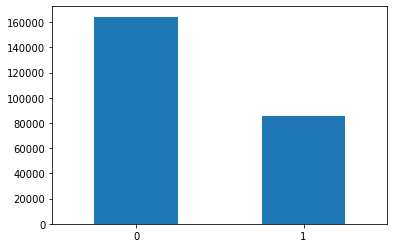

In [6]:
balance = collections.Counter(y)
balance = [balance[-1], balance[1]]
vis = pd.Series(balance, index=range(len(balance)))
vis.plot(kind="bar", rot=0)
plt.plot()

## Calculating the F1-score for a fit

In [7]:
def f1_score(y_valid, tX_valid, weights):
    """
    Return the F1-score achieved with the predictions of a validation set
    
    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for the Precision and recall
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for F-score
        https://en.wikipedia.org/wiki/F-score

    """

    # Obtaining the predictions
    y_pred = predict_labels(weights, tX_valid)

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)

    f1 = 2 * precision * recall / (precision + recall)

    return f1

# Regressors

## Least squares gradient descent

In [8]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.1

# Fitting
weights, loss = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_GD': F1 = ", f1)

F1-score achieved with 'least_squares_GD': F1 =  0.6524918119854829


 ## Least squares stochastic gradient descent

In [9]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 10000
gamma = 0.001

# Fitting
weights, loss = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_SGD': F1 = ", f1)

F1-score achieved with 'least_squares_SGD': F1 =  0.6519128941045909


## Least squares (normal equation)

In [10]:
# Fitting
weights, loss = least_squares(y_train, tX_train)

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares': F1 = ", f1)

F1-score achieved with 'least_squares': F1 =  0.6655814257451624


## Ridge regression (for least squares normal equation)

In [11]:
# Hyperparameters
lambda_ = 0.1

# Fitting
weights, loss = ridge_regression(y_valid, tX_valid, lambda_)

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
print("F1-score achieved with 'ridge_regression': F1 = ", f1)

F1-score achieved with 'ridge_regression': F1 =  0.6569262674430867


## Logistic regression

In [12]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
weights, loss = logistic_regression(y, tX, initial_w, max_iters, gamma)

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

F1-score achieved with 'logistic_regression': F1 =  0.663528832514683


## Regularized logistic regression

In [13]:
# Hyperparameters
lambda_ = 1
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
weights, loss = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
print("F1-score achieved with 'reg_logistic_regression': F1 = ", f1)

F1-score achieved with 'reg_logistic_regression': F1 =  0.6637189418684432


## Generate predictions and save ouput in csv format for submission

In [51]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)